<a href="https://colab.research.google.com/github/Howlbeeb/ML-Projects/blob/master/Multi_Class_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Firstly Creating a dataset for MultiClass Classification


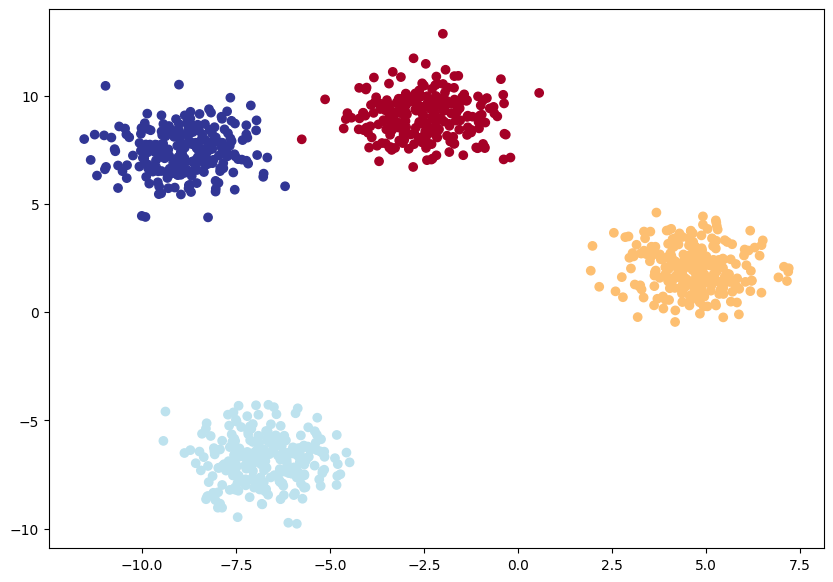

In [ ]:
# Import Dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set hyperparameters for Blob creation dataset
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# Make blob dataset
X_blob,y_blob = make_blobs(n_samples=1000,n_features=NUM_FEATURES,centers=NUM_CLASSES, random_state=RANDOM_SEED)

#2 Turn data into Tensor
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

#3 Split the dataset
X_blob_train,X_blob_test,y_blob_train,y_blob_test = train_test_split(X_blob,y_blob,test_size=0.2, random_state=RANDOM_SEED)
# 4 Visualize and plot Data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob, cmap=plt.cm.RdYlBu)

In [ ]:
# Create device agnostic code
from torch import nn
device ='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Creating a multi-class Classification model

In [ ]:
class BlobModel(nn.Module):
  def __init__(self,input_features,output_features,hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_features)
    )
  def forward(self,x):
    return self.linear_layer_stack(x)

model_5 = BlobModel(input_features=2,output_features=4,hidden_units=8).to(device)
model_5

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU6()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_5.parameters(),lr=0.1)

In [ ]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_5(X_blob_train.to(device))[:5]

tensor([[ 0.6068, -0.6350, -0.6560, -0.3328],
        [ 0.5828, -0.6529, -0.6595, -0.3187],
        [ 0.4188, -0.5227, -0.1665, -0.1978],
        [ 0.3504, -0.4534, -0.2157, -0.2177],
        [ 0.4789, -0.5947, -0.5712, -0.2770]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [ ]:
# Make prediction logits with model
y_logits = model_5(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.6253, -0.6706, -0.6911, -0.3472],
        [ 0.6210, -0.3735, -0.6682, -0.4595],
        [ 0.3631, -0.5135, -0.1406, -0.1530],
        [ 0.4455, -0.5481, -0.4898, -0.2582],
        [ 0.6787, -0.7136, -0.7465, -0.3614]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.5209, 0.1425, 0.1396, 0.1970],
        [0.5038, 0.1864, 0.1388, 0.1710],
        [0.3821, 0.1590, 0.2309, 0.2280],
        [0.4430, 0.1640, 0.1738, 0.2192],
        [0.5428, 0.1349, 0.1305, 0.1918]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [10]:
# Calculate Accuracy

def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred)) *100
  return acc

In [13]:
## 4. Boundary decision using function from a raw source

import requests
from pathlib import Path
# download helper functions if not already downloaded
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions,plot_decision_boundary

### Creating Training and Testing Loop

In [ ]:
torch.cuda.manual_seed(42)

epochs = 100

# Putting data to target device
X_blob_train,y_blob_train = X_blob_train.to(device),y_blob_train.to(device)
X_blob_test,y_blob_test = X_blob_test.to(device),y_blob_test.to(device)

for epoch in range(epochs):
  model_5.train()
  # 1 Forward pass
  y_logits = model_5(X_blob_train)
  y_preds = torch.softmax(y_logits,dim=1).argmax(dim=1)
  #2 calculate the loss
  loss = loss_fn(y_logits,y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,y_pred=y_preds)

  #3 Optimizer zero grad
  optimizer.zero_grad()

  #4 Loss backward
  loss.backward()

  #5 Optimizer step
  optimizer.step()

  # Testing
  model_5.eval()
  with torch.inference_mode():
    # do the forward pass
    test_logits = model_5(X_blob_test)
    test_preds = torch.softmax(test_logits,dim=1).argmax(dim=1)
    # calculate loss and acccuracy
    test_loss = loss_fn(test_logits,y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,y_pred=test_preds)

  # print what's happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.45738, Acc: 25.12% | Test Loss: 1.37123, Test Acc: 24.50%
Epoch: 10 | Loss: 1.06871, Acc: 49.75% | Test Loss: 1.02108, Test Acc: 51.00%
Epoch: 20 | Loss: 0.71837, Acc: 74.50% | Test Loss: 0.69440, Test Acc: 71.00%
Epoch: 30 | Loss: 0.40852, Acc: 99.25% | Test Loss: 0.39299, Test Acc: 99.50%
Epoch: 40 | Loss: 0.20416, Acc: 99.88% | Test Loss: 0.19463, Test Acc: 100.00%
Epoch: 50 | Loss: 0.10997, Acc: 99.88% | Test Loss: 0.10376, Test Acc: 100.00%
Epoch: 60 | Loss: 0.06954, Acc: 99.88% | Test Loss: 0.06497, Test Acc: 100.00%
Epoch: 70 | Loss: 0.04936, Acc: 99.88% | Test Loss: 0.04556, Test Acc: 100.00%
Epoch: 80 | Loss: 0.03782, Acc: 99.88% | Test Loss: 0.03442, Test Acc: 100.00%
Epoch: 90 | Loss: 0.03052, Acc: 99.88% | Test Loss: 0.02737, Test Acc: 100.00%


In [ ]:
# make some Evaluation
model_5.eval()
with torch.inference_mode():
  y_logits = model_5(X_blob_test)
y_logits[:5]

tensor([[ 1.4219,  5.3820, -2.5827, -5.8545],
        [-0.1581, -4.4771, -3.4565,  3.6780],
        [-2.5014, -0.0997,  5.8968, -1.1253],
        [ 0.7467,  4.5761, -1.7675, -4.8691],
        [ 3.9821,  0.0445, -6.8378, -1.7718]], device='cuda:0')

In [ ]:
y_preds_probs = torch.softmax(y_logits,dim=1)
# Converting it to Labels
y_labels = y_preds_probs.argmax(dim=1)
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_labels)}%")

Predictions: tensor([1, 0, 2, 2, 0, 0, 0, 1, 3, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 100.0%


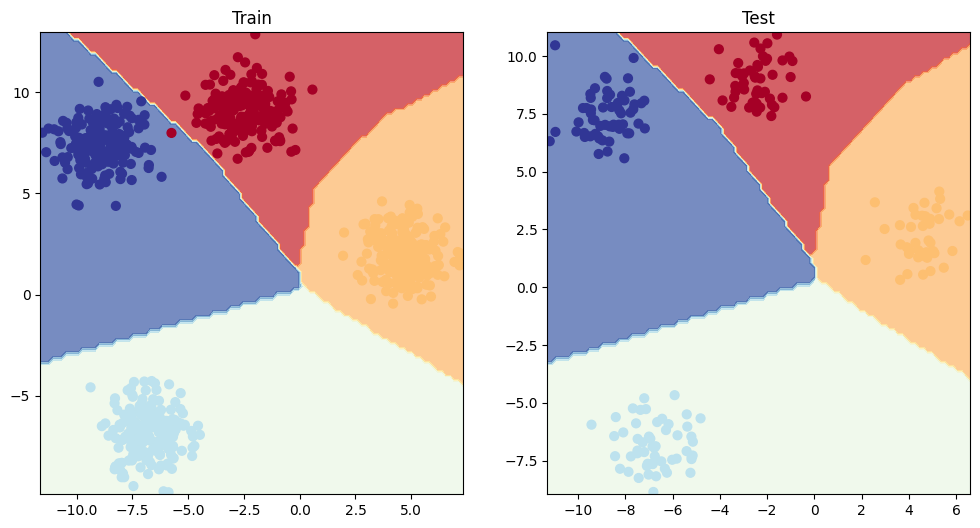

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_5, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_5, X_blob_test, y_blob_test)

In [ ]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_labels, y_blob_test)

tensor(1., device='cuda:0')

## Excercises

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device
RANDOM_SEED=42

In [ ]:
# Making Dataset
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd
X_moon,y_moon = make_moons(n_samples=1000, random_state=RANDOM_SEED,noise=0.03)
moons = pd.DataFrame({'X1':X_moon[:,0],'X2':X_moon[:,1],'label':y_moon})
moons.head(10)

,X1,X2,label
0,-0.009332,0.390981,1
1,0.954574,-0.473756,1
2,0.918526,-0.425196,1
3,0.412768,-0.376385,1
4,-0.845320,0.528799,0
5,0.579542,-0.352979,1
6,0.294884,-0.209238,1
7,-0.014488,0.435896,1
8,1.626510,-0.281207,1
9,0.671598,0.786422,0


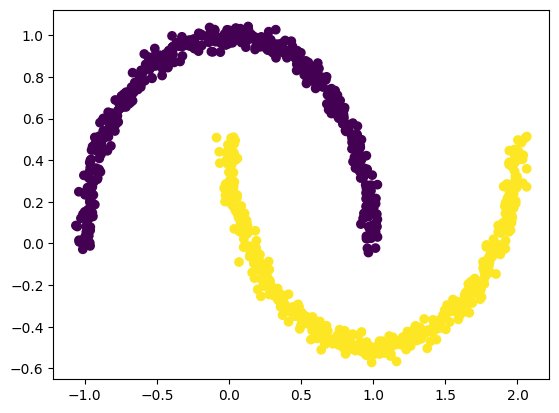

In [ ]:
plt.scatter(X_moon[:,0],X_moon[:,1],c=y_moon)

In [ ]:
X_moon =torch.from_numpy(X_moon).type(torch.float)
y_moon =torch.from_numpy(y_moon).type(torch.float)
X_moon[:5]

tensor([[-0.0093,  0.3910],
        [ 0.9546, -0.4738],
        [ 0.9185, -0.4252],
        [ 0.4128, -0.3764],
        [-0.8453,  0.5288]])

In [ ]:
from sklearn.model_selection import train_test_split
X_moon_train,X_moon_test,y_moon_train,y_moon_test = train_test_split(X_moon,y_moon,test_size=0.2,random_state=RANDOM_SEED)

In [ ]:
# Build a model by subclassing nn.Module
from torch import nn
class MoonModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2,out_features=10)
    self.layer2 = nn.Linear(in_features=10,out_features=10)
    self.layer3 = nn.Linear(in_features=10,out_features=10)
    self.layer4 = nn.Linear(in_features=10,out_features=1)
    self.relu = nn.ReLU()
  def forward(self,x):
    return self.layer4(self.relu(self.layer3(self.layer2(self.layer1(x)))))

model_6 = MoonModel().to(device)
model_6

MoonModel(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=10, bias=True)
  (layer4): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_6.parameters(),lr=0.1)

In [ ]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)

X_moon_train,y_moon_train = X_moon_train.to(device),y_moon_train.to(device)
X_moon_test,y_moon_test = X_moon_test.to(device),y_moon_test.to(device)

epochs=1000

for epoch in range(epochs):
  model_6.train()
  y_logits = model_6(X_moon_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits,y_moon_train)
  acc = accuracy_fn(y_true = y_moon_train,y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_6.eval()
  with torch.inference_mode():
    test_logits = model_6(X_moon_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits,y_moon_test)
    test_acc = accuracy_fn(y_true=y_moon_test,y_pred=test_pred)
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

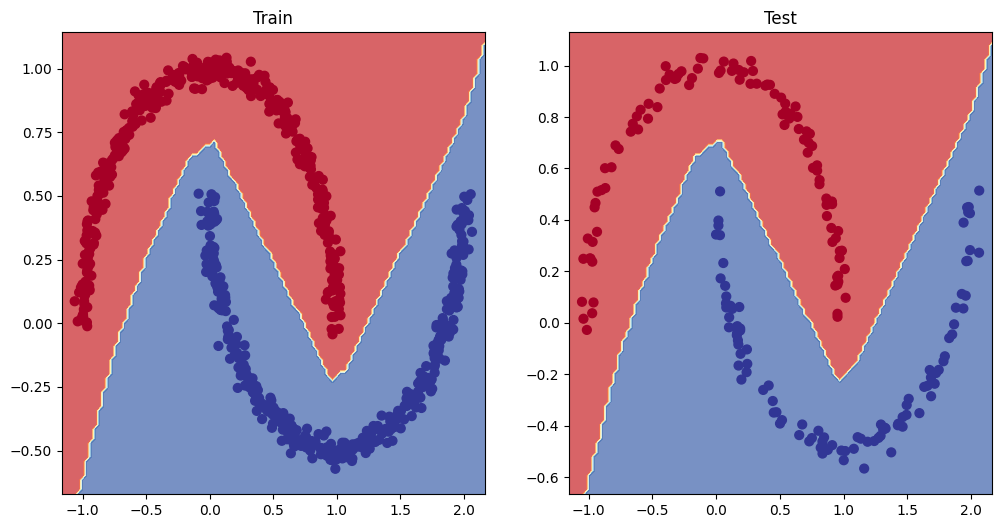

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_6, X_moon_train, y_moon_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_6, X_moon_test, y_moon_test)

## Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).

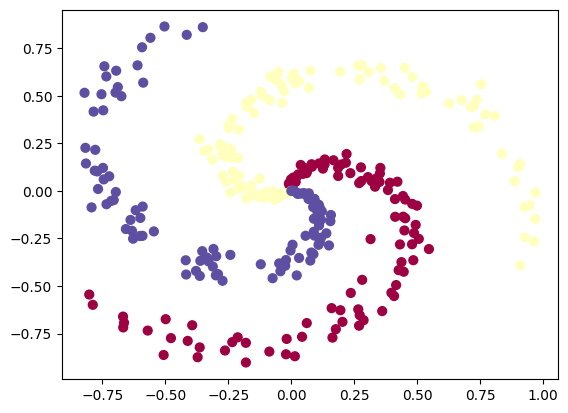

In [17]:
import numpy as np
import matplotlib.pyplot as plt
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [2]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [48]:

from torch import nn
class SpiralModel(nn.Module):
  def __init__(self,input_features,output_features,hidden_units):
    super().__init__()
    self.layer_stacked = nn.Sequential(
        nn.Linear(in_features=input_features,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_features)
    )

  def forward(self,x):
    return self.layer_stacked(x)

model_7 = SpiralModel(input_features=2,output_features=3,hidden_units=8).to(device)
model_7

SpiralModel(
  (layer_stacked): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=3, bias=True)
  )
)

In [49]:
# from numpy to tensor
import torch
from sklearn.model_selection import train_test_split
RANDOM_SEED=42
X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.LongTensor)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=RANDOM_SEED)

TypeError: expected np.ndarray (got Tensor)

In [50]:
loss_fn = nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params =model_7.parameters(),lr=0.01)

In [51]:
model_7(X_train.to(device))[:5]

tensor([[-0.0742, -0.3527, -0.2342],
        [-0.0905, -0.3452, -0.2553],
        [-0.0720, -0.3837, -0.2497],
        [-0.2065, -0.3702, -0.4323],
        [-0.1337, -0.4217, -0.3531]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [52]:
# Make prediction logits with model
y_logits = model_7(X_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.0731, -0.3824, -0.2450],
        [-0.0466, -0.3110, -0.1849],
        [-0.0881, -0.4143, -0.2930],
        [-0.0748, -0.3887, -0.2544],
        [-0.0655, -0.3513, -0.2202]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.3882, 0.2849, 0.3269],
        [0.3790, 0.2910, 0.3300],
        [0.3943, 0.2845, 0.3212],
        [0.3897, 0.2847, 0.3256],
        [0.3834, 0.2881, 0.3285]], device='cuda:0', grad_fn=<SliceBackward0>)


In [53]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)

X_train,y_train=X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)

epochs =1000
for epoch in range(epochs):
  model_7.train()
  y_logits = model_7(X_train).squeeze()
  y_preds = torch.softmax(y_logits,dim=1).argmax(dim=1)

  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true=y_train,y_pred=y_preds)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_7.eval()
  with torch.inference_mode():
    test_logits = model_7(X_test).squeeze()
    test_preds = torch.softmax(test_logits,dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true=y_test,y_pred=test_preds)
  if epoch%100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.10351, Acc: 32.50% | Test Loss: 1.08531, Test Acc: 36.67%
Epoch: 100 | Loss: 0.51188, Acc: 72.50% | Test Loss: 0.57473, Test Acc: 61.67%
Epoch: 200 | Loss: 0.27887, Acc: 89.58% | Test Loss: 0.26033, Test Acc: 88.33%
Epoch: 300 | Loss: 0.12118, Acc: 95.83% | Test Loss: 0.08279, Test Acc: 96.67%
Epoch: 400 | Loss: 0.06742, Acc: 97.50% | Test Loss: 0.03396, Test Acc: 100.00%
Epoch: 500 | Loss: 0.05204, Acc: 98.75% | Test Loss: 0.01858, Test Acc: 100.00%
Epoch: 600 | Loss: 0.04402, Acc: 98.75% | Test Loss: 0.01212, Test Acc: 100.00%
Epoch: 700 | Loss: 0.03857, Acc: 98.75% | Test Loss: 0.00864, Test Acc: 100.00%
Epoch: 800 | Loss: 0.03437, Acc: 98.75% | Test Loss: 0.00632, Test Acc: 100.00%
Epoch: 900 | Loss: 0.03113, Acc: 99.17% | Test Loss: 0.00489, Test Acc: 100.00%


In [54]:
model_7.eval()
with torch.inference_mode():
  y_logits = model_7(X_test)
y_logits[:5]

tensor([[  3.2725,   4.9593,   7.9741],
        [-11.4505,   4.3415,  10.8549],
        [  7.2127,  13.0660,  -9.5815],
        [ 15.3924,   2.8399,  -1.0641],
        [  3.9573, -10.3835,  26.8762]], device='cuda:0')

In [55]:
y_preds_probs = torch.softmax(y_logits,dim=1)
# Converting it to Labels
y_labels = y_preds_probs.argmax(dim=1)
print(f"Predictions: {y_preds[:10]}\nLabels: {y_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_test, y_pred=y_labels)}%")

Predictions: tensor([2, 0, 0, 1, 1, 0, 0, 2, 0, 1], device='cuda:0')
Labels: tensor([2, 2, 1, 0, 2, 2, 1, 1, 0, 1], device='cuda:0')
Test accuracy: 100.0%


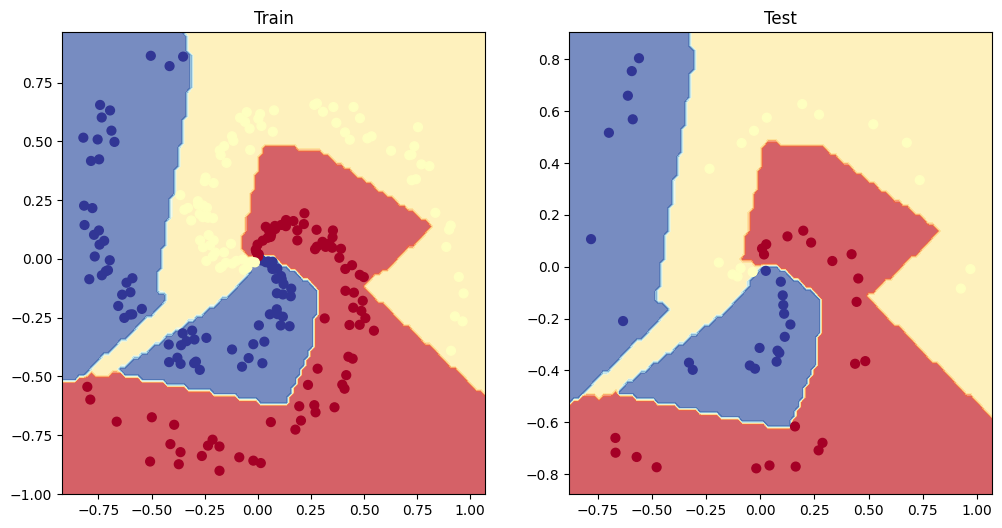

In [56]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_7, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_7, X_test, y_test)

In [43]:

from torch import nn
class SpiralModel2(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(in_features=2, out_features=10)
    self.linear2 = nn.Linear(in_features=10, out_features=10)
    self.linear3 = nn.Linear(in_features=10, out_features=3)
    self.relu = nn.ReLU()

  def forward(self,x):
    return self.linear3(self.relu(self.linear2(self.linear1(x))))

In [44]:
model_8 = SpiralModel2().to(device)
model_8

SpiralModel2(
  (linear1): Linear(in_features=2, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=10, bias=True)
  (linear3): Linear(in_features=10, out_features=3, bias=True)
  (relu): ReLU()
)

In [45]:
loss_fn =nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params =model_8.parameters(),lr=0.02)

In [46]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)

X_train,y_train=X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)

epochs =1000
for epoch in range(epochs):
  model_8.train()
  y_logits = model_8(X_train)
  y_preds = torch.softmax(y_logits,dim=1).argmax(dim=1)

  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true=y_train,y_pred=y_preds)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_8.eval()
  with torch.inference_mode():
    test_logits = model_8(X_test)
    test_preds = torch.softmax(test_logits,dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true=y_test,y_pred=test_preds)
  if epoch%100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.11700, Acc: 32.50% | Test Loss: 1.08810, Test Acc: 36.67%
Epoch: 100 | Loss: 0.31452, Acc: 85.42% | Test Loss: 0.28727, Test Acc: 86.67%
Epoch: 200 | Loss: 0.15671, Acc: 93.33% | Test Loss: 0.11855, Test Acc: 96.67%
Epoch: 300 | Loss: 0.11171, Acc: 95.42% | Test Loss: 0.07548, Test Acc: 98.33%
Epoch: 400 | Loss: 0.09286, Acc: 96.25% | Test Loss: 0.05849, Test Acc: 96.67%
Epoch: 500 | Loss: 0.06909, Acc: 97.50% | Test Loss: 0.03403, Test Acc: 100.00%
Epoch: 600 | Loss: 0.05789, Acc: 98.75% | Test Loss: 0.02203, Test Acc: 100.00%
Epoch: 700 | Loss: 0.04924, Acc: 98.75% | Test Loss: 0.01575, Test Acc: 100.00%
Epoch: 800 | Loss: 0.04538, Acc: 98.33% | Test Loss: 0.00946, Test Acc: 100.00%
Epoch: 900 | Loss: 0.04075, Acc: 98.75% | Test Loss: 0.00698, Test Acc: 100.00%


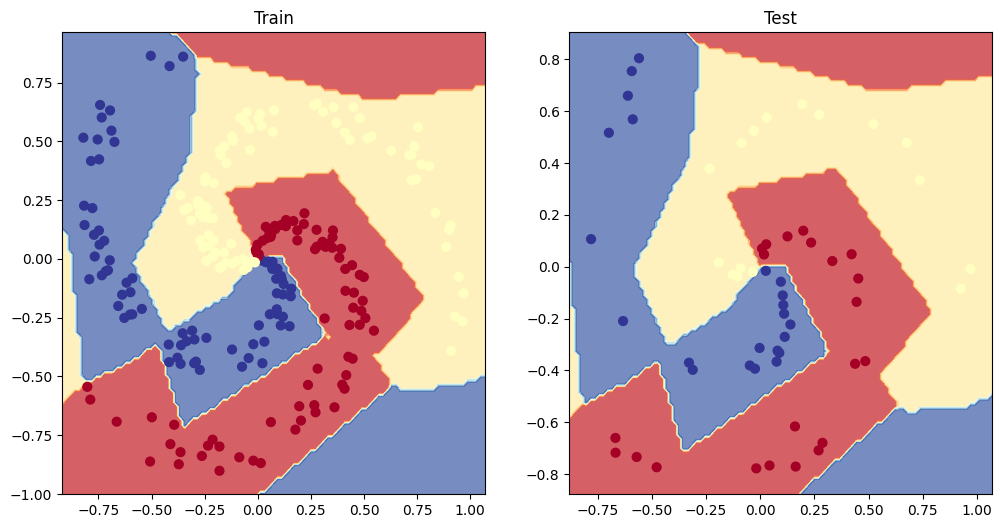

In [47]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_8, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_8, X_test, y_test)